<a href="https://colab.research.google.com/github/mroshan454/Replicating-ViT-Research-Paper/blob/main/Replicating_The_ViT_Paper_from_Scratch.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Replicating The Vision Transformer Research Paper from Scratch

In this notebook , I will be attempting to replicate the 2020 Research paper:

 "AN IMAGE IS WORTH 16X16 WORDS: TRANSFORMERS FOR IMAGE RECOGNITION AT SCALE ,
Where the Vision Transformer (ViT) attains excellent results compared to state-of-the-art convolutional networks while requiring sub- stantially fewer computational resources to train.

The goal of machine learning research paper replicating is to turn a ML Research Paper into usable code.





For replicating this research paper , I'm using a custom dataset containing images facial expressions which are happy , sad and angry. The dataset name is FER-2013 which can be found on Kaggle.

What I'm using for this project is just 3 expressions only so that I can train the ViT Base model to classify these three facial expressions.


## 0. Importing required libraries

In [ ]:
# For this notebook to run with updated APIs, we need torch 1.12+ and torchvision 0.13+
try:
    import torch
    import torchvision
    assert int(torch.__version__.split(".")[1]) >= 12 or int(torch.__version__.split(".")[0]) == 2, "torch version should be 1.12+"
    assert int(torchvision.__version__.split(".")[1]) >= 13, "torchvision version should be 0.13+"
    print(f"torch version: {torch.__version__}")
    print(f"torchvision version: {torchvision.__version__}")
except:
    print(f"[INFO] torch/torchvision versions not as required, installing nightly versions.")
    !pip3 install -U torch torchvision torchaudio --index-url https://download.pytorch.org/whl/cu118
    import torch
    import torchvision
    print(f"torch version: {torch.__version__}")
    print(f"torchvision version: {torchvision.__version__}")

torch version: 2.6.0+cu124
torchvision version: 0.21.0+cu124


## 1. Get Data

In [ ]:
import os
import zipfile

from pathlib import Path

import requests

#Setup path to data folder
data_path = Path("data/")
image_path = data_path / "happy_angry_sad"

#If image folder does'nt exist , download it and prepare it...
if image_path.is_dir():
  print(f"{image_path} directory exists")
else:
  print(f"Did not find {image_path} directory , creating one....")
  image_path.mkdir(parents=True, exist_ok=True)

#Download happy , angry , sad data
with open(data_path / "happy_angry_sad.zip","wb") as f:
  request = requests.get("https://github.com/mroshan454/Replicating-ViT-Research-Paper/raw/main/happy_angry_sad.zip")
  print("Downloading data...")
  f.write(request.content)

#Unzip happy,angry,sad data
with zipfile.ZipFile(data_path / "happy_angry_sad.zip","r") as zip_ref:
  print("Unzipping happy_angry_sad data...")
  zip_ref.extractall(image_path)

#Remove zip file
os.remove(data_path / "happy_angry_sad.zip")


Did not find data/happy_angry_sad directory , creating one....
Unzipping happy_angry_sad data...


In [ ]:
#Setup train and test directory
train_dir = image_path / "train"
test_dir = image_path / "test"

train_dir , test_dir

(PosixPath('data/happy_angry_sad/train'),
 PosixPath('data/happy_angry_sad/test'))

## 2. Create datasets and dataloaders

Now we'll turn the data into PyTorch `Datasets` and `Dataloader's`

In [ ]:
from torchvision import datasets , transforms

#Create simple transforms
data_transform = transforms.Compose([
    transforms.Resize((224,224)),
    transforms.Grayscale(num_output_channels=3),
    transforms.ToTensor(),
])

#Use image folder to create dataset
train_data = datasets.ImageFolder(root=train_dir, #Target folder of images
                                 transform=data_transform, #Transforms to perform on data (images)
                                 target_transform=None) #Transforms to perform on labels (if necessary)
test_data = datasets.ImageFolder(root=test_dir,
                                 transform=data_transform)
print(f"Train Data:\n{train_data}\nTest Data:\n{test_data}")

Train Data:
Dataset ImageFolder
    Number of datapoints: 16040
    Root location: data/happy_angry_sad/train
    StandardTransform
Transform: Compose(
               Resize(size=(224, 224), interpolation=bilinear, max_size=None, antialias=True)
               Grayscale(num_output_channels=3)
               ToTensor()
           )
Test Data:
Dataset ImageFolder
    Number of datapoints: 3979
    Root location: data/happy_angry_sad/test
    StandardTransform
Transform: Compose(
               Resize(size=(224, 224), interpolation=bilinear, max_size=None, antialias=True)
               Grayscale(num_output_channels=3)
               ToTensor()
           )


In [ ]:
#Get class names as a list
class_names = train_data.classes
class_names

['angry', 'happy', 'sad']

In [ ]:
#Can also get class names as a dict
class_dict = train_data.class_to_idx
class_dict

{'angry': 0, 'happy': 1, 'sad': 2}

In [ ]:
#Check lengths
len(train_data), len(test_data)

(16040, 3979)

data/happy_angry_sad/train/happy/Training_68546508.jpg
happy
Random Image Path: data/happy_angry_sad/train/happy/Training_68546508.jpg
Image Class : happy
Image Height : 48
Image Width : 48


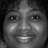

In [ ]:
import random
from PIL import Image

#Set seed
#random.seed(42)

# 1.Get all image paths
image_path_list = list(image_path.glob("*/*/*.jpg"))

# 2. Pick a random image path
random_image_path = random.choice(image_path_list)
print(random_image_path)

# 3. Get image class from the path name ( the image class is the name of the directory where the image is stored )
image_class = random_image_path.parent.stem
print(image_class)

# 4. Open image
img = Image.open(random_image_path)

#5. Print metadata
print(f"Random Image Path: {random_image_path}")
print(f"Image Class : {image_class}")
print(f"Image Height : {img.height}")
print(f"Image Width : {img.width}")
img

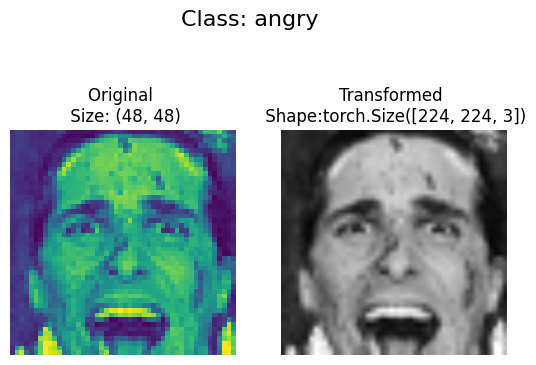

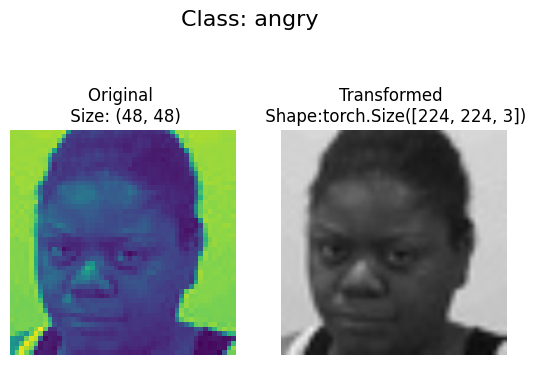

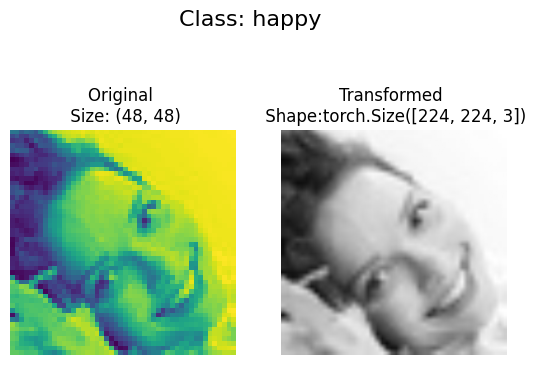

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
def plot_transformed_images(image_paths:list,transform,n=3,seed=42):
  """
  Selects random images from a path of image and loads/transforms
  them then plots the original vs the transformed version
  """
  if seed:
    random.seed(seed)
  random_image_paths = random.sample(image_paths,k=n)
  for image_path in random_image_paths:
    with Image.open(image_path) as f:
      fig ,ax = plt.subplots(nrows=1, ncols=2)
      ax[0].imshow(f)
      ax[0].set_title(f"Original \n Size: {f.size}")
      ax[0].axis(False)

      #Transform and plot target image
      transformed_image = transform(f).permute(1,2,0) #Note we will need to change shape for matplotlib (C,H,W) -> (H,W,C)
      ax[1].imshow(transformed_image)
      ax[1].set_title(f"Transformed \n Shape:{transformed_image.shape}")
      ax[1].axis("off")

      fig.suptitle(f"Class: {image_path.parent.stem}",fontsize=16)


plot_transformed_images(image_paths=image_path_list,
                        transform=data_transform,
                        n=3,
                        seed=42)

In [ ]:
# Turn train and test datasets into DataLoader's
from torch.utils.data import DataLoader
BATCH_SIZE = 32
train_dataloader = DataLoader(dataset=train_data,
                              batch_size=BATCH_SIZE,
                              num_workers=1,
                              shuffle=True)
test_dataloader = DataLoader(dataset=test_data,
                             batch_size=BATCH_SIZE,
                             num_workers=1,
                             shuffle=False)
train_dataloader , test_dataloader

(<torch.utils.data.dataloader.DataLoader at 0x7a7fbfd87410>,
 <torch.utils.data.dataloader.DataLoader at 0x7a7fc061c6d0>)

## 3. Replicating ViT : Overview

Rather than looking at whole machine learning paper , we can make it more understandable by breaking it down into smaller blocks.

* **Inputs** - What goes into the model?(in our case,image tensors)
* **Outputs** - What comes out of the model/layer/block? (In our case, we want the model to output image classification labels)
* **Layers** - Takes an input , manipulates it with a function eg:Self-Attention.
* **Blocks** - A collection of layers.
* **Model or Architecture** - A collection of blocks.

### 3.1 ViT Figure 1
<img src="https://github.com/mroshan454/Replicating-ViT-Research-Paper/blob/main/images/Fig.1.VIT.png?raw=true" width=900 alt="figure 1 from the original vision transformer paper"/>


**Figure 1 Explained Visually:**

<img src="https://github.com/mroshan454/Replicating-ViT-Research-Paper/blob/main/images/1.png?raw=true" width=900 alt="figure 1 explained visually"/>

### 3.2 Four Equations

<img src="https://github.com/mroshan454/Replicating-ViT-Research-Paper/blob/main/images/Four%20Equations.png?raw=true" width=900 alt="four equations"/>

These are the four equations that is used throughout this research paper.


#### **Equation 1: Explained Visually**

<img src="https://github.com/mroshan454/Replicating-ViT-Research-Paper/blob/main/images/2.png?raw=true" width=900 alt="equation 1 explained visually"/>

The Equation 1 shows that the images are converted into patches , and linearly embedd each other together and one extra learnable class embedding is added , and after that each position embeddings are given to each patches including the Extra Learnable class embedding.

We are using 1-D Patch Embeddings because , there is no significant performance gain from using the advanced 2D- Aware position embeddings.(Appendix D.4)

The Equation is converted into a pseudocode later which we can turn it into PyTorch code.


#### **Equation 2 & 3: Explained Visually**

<img src="https://github.com/mroshan454/Replicating-ViT-Research-Paper/blob/main/images/3.png?raw=true" width=900 alt="equation 3 explained visually"/>

<img src="https://github.com/mroshan454/Replicating-ViT-Research-Paper/blob/main/images/4.png?raw=true" width=900 alt="equation 4 explained visually"/>

The Transformer encoder (Vaswani et al., 2017) consists of alternating layers of multiheaded selfattention (MSA, see Appendix A) and MLP blocks (Eq. 2, 3). Layernorm (LN) is applied before every block, and residual connections after every block (Wang et al., 2019; Baevski \& Auli, 2019).

#### **Equation 4: Explained Visually**

<img src="https://github.com/mroshan454/Replicating-ViT-Research-Paper/blob/main/images/5.png?raw=true" width=900 alt="equation 5 explained visually"/>

**Equation 4:**
Similar to BERT's [class] token, we prepend a learnable embedding to the sequence of embedded patches ( $\mathrm{z}_0^0=\mathrm{x}_{\text {class }}$ ), whose state at the output of the Transformer encoder ( $\mathrm{z}_L^0$ ) serves as the image representation y (Eq. 4). Both during pre-training and fine-tuning, a classification head is attached to $\mathbf{z}_L^0$. The classification head is implemented by a MLP with one hidden layer at pre-training time and by a single linear layer at fine-tuning time.


* MLP = Multilayer Perceptron = a neural network with X number of layers
* MLP = one hidden layer at training time
* MLP = single linear layer at fine tuning time